In [17]:
import numpy as np
import sys, os
import rospy
import rosbag
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
import time 
from pprint import pprint
from tqdm.auto import tqdm

In [18]:
frequency = 30 #Hz
bag_file_name = '/data/dataset_ENVTACT_new2.bag'
time_window_size = 6
examples_per_edge = 1

def generateFrames(event_list, time_steps, im_height=260, im_width=346, im_channel=3, time_window=None):
        event_iterator = 0
        channel = 0
        x = [0, 0, 0]
        event_image = np.zeros((im_height, im_width, im_channel), dtype=np.float32)
        for ts in time_steps:
            
            for i in range(event_iterator, len(event_list)):
                event_iterator = i + 1
                event = np.copy(event_list[i]) #[x, y, ts, polarity]
                if (time_window==None) or (event[2] > ts - time_window):
                    if event[2] > ts:
                        event_image[201, 154, 0] = 0
                        channel = channel + 1
                        #print("cahnnel = ", channel)
                        break
                    else:
                        # print("ha")
                        x[channel] = x[channel] + 1
                        if event[3] > 0:
                            event_image[int(event[1]), int(event[0]), channel] = event_image[int(event[1]), int(event[0]), channel] + 1.0
                        else:
                            event_image[int(event[1]), int(event[0]), channel] = event_image[int(event[1]), int(event[0]), channel] - 1.0             
        
        return event_image

def cropFrames(image, circle_center=(173, 130), circle_rad=100, im_height=260, im_width=346, im_channels=3):
        mask = np.zeros((im_height, im_width, im_channels), dtype=np.float32)            
        cv2.circle(mask, circle_center, circle_rad, [1]*im_channels, -1, 8, 0)
        cropped_image = np.multiply(mask, image)

        return cropped_image


def filter_events_by_time(events, time_of_contact, time_period = 0.3e9, threshold=7500):
    event_in_time_idx = np.where((event_time > (time_of_contact - time_period)) * (event_time < time_of_contact))[0]
    #print(len(event_in_time_idx))
    #time_of_contact - time_period < ts < time_of_contact
    if len(event_in_time_idx) < threshold:
        return False, []
    else:
        #print(event_in_time_idx)
        output_events = np.array(events)[event_in_time_idx,:]
        return True, output_events

In [19]:

events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []

contact_case_updated = []
contact_case_updated_ts = []


#generate labels
possible_angle = [0.0174532925, 0.034906585, 0.0523598776, 0.075, 0.095, 0.115, 0.135, 0.15] #data generation process
N_examples = 9
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * np.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * np.cos(theta)
        ry = phi * np.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(len(list_of_rotations))
pprint(list_of_rotations)

65
[[0, 0, 0],
 [0.01234134148078231, 0.012341341480782309, 0],
 [0.02468268296156462, 0.024682682961564617, 0],
 [0.03702402451305761, 0.037024024513057606, 0],
 [0.053033008588991064, 0.05303300858899106, 0],
 [0.06717514421272203, 0.06717514421272201, 0],
 [0.08131727983645297, 0.08131727983645295, 0],
 [0.09545941546018392, 0.09545941546018391, 0],
 [0.10606601717798213, 0.10606601717798211, 0],
 [1.0687059397353753e-18, 0.0174532925, 0],
 [2.1374118794707506e-18, 0.034906585, 0],
 [3.2061178253293598e-18, 0.0523598776, 0],
 [4.592425496802574e-18, 0.075, 0],
 [5.817072295949928e-18, 0.095, 0],
 [7.04171909509728e-18, 0.115, 0],
 [8.266365894244634e-18, 0.135, 0],
 [9.184850993605149e-18, 0.15, 0],
 [-0.012341341480782309, 0.01234134148078231, 0],
 [-0.024682682961564617, 0.02468268296156462, 0],
 [-0.037024024513057606, 0.03702402451305761, 0],
 [-0.05303300858899106, 0.053033008588991064, 0],
 [-0.06717514421272201, 0.06717514421272203, 0],
 [-0.08131727983645295, 0.0813172798364

In [20]:
possible_angle = [0.0174532925, 0.034906585, 0.0523598776, 0.075, 0.095, 0.115, 0.135, 0.15] #data generation process
N_examples = 9
list_of_rotations = [[0, 0, 0]]
import numpy as np
for i in range(1, N_examples):
    theta = i * 2 * np.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * np.cos(theta)
        ry = phi * np.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(len(list_of_rotations))

65


In [21]:
bag_file = rosbag.Bag(bag_file_name)


for topic, msg, t in tqdm(bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle'])):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
        event_topic = True    
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt(np.power(rot[0]-msg.x, 2)+np.power(rot[1]-msg.y, 2)+np.power(rot[2]-msg.z, 2))
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1
                    #print(best_rot_diff, best_rot_idx)

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else: 
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())
        
        # Updated contact status according to no. of events
        
            
#print(events)
bag_file.close()

419697it [02:35, 2707.19it/s]


In [22]:
event_time = np.array([events[i][2] for i in range(np.shape(events)[0])])
event_time.shape

(11138715,)

In [69]:
#interpolate
#this will get a uniform grid of events at frequency = 30Hz
f = interp1d(contact_case_ts, contact_case, kind='previous')
contact_case_ts_int = range(min(contact_case_ts), max(contact_case_ts), int(1e9/frequency))
contact_case_int = f(contact_case_ts_int)

In [24]:
len(contact_case), len(contact_case_int)

(161245, 96927)

<BarContainer object of 66 artists>

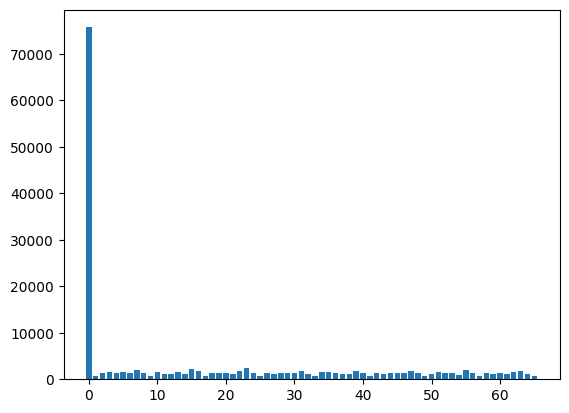

In [25]:
plt.bar(*np.unique(contact_case, return_counts=True))

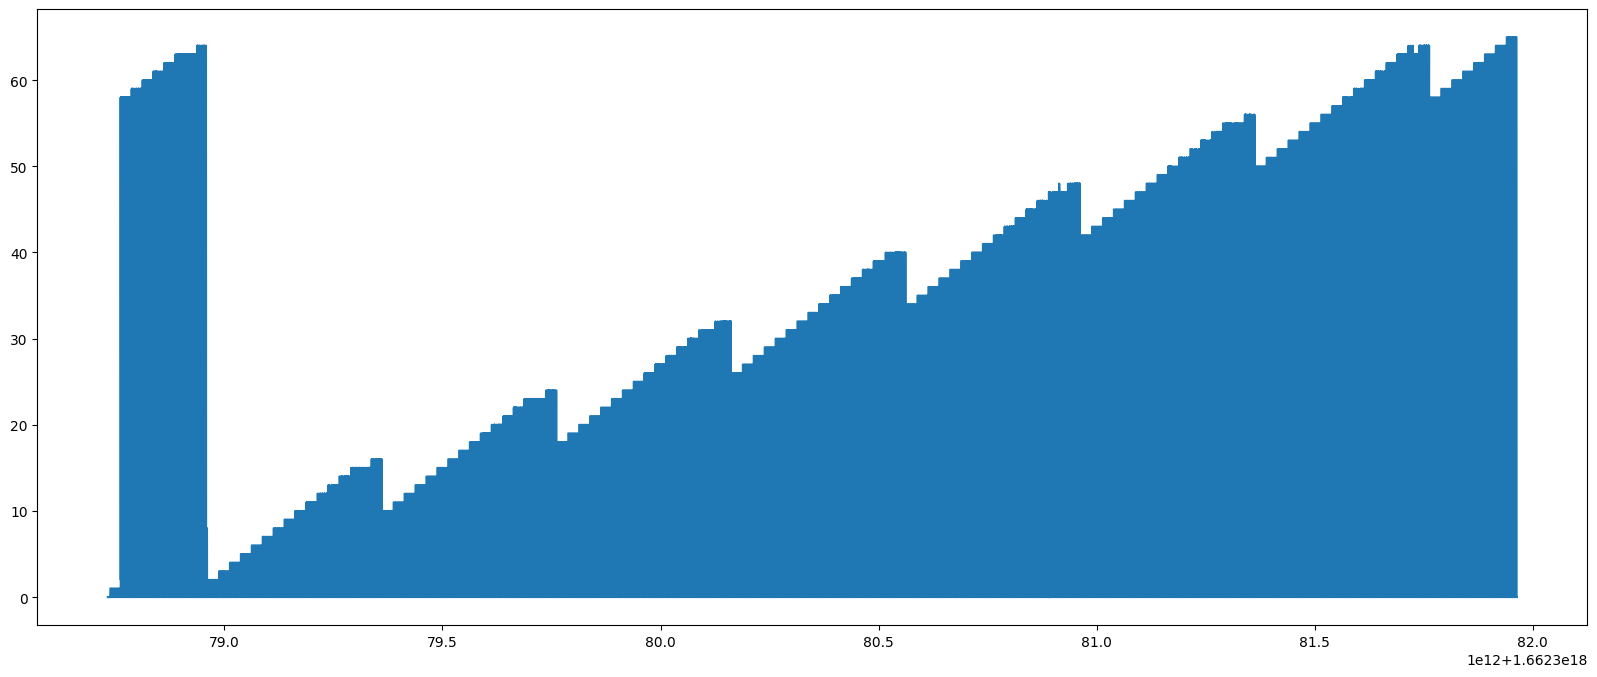

96927


In [26]:
plt.figure(figsize=(20,8))
plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))

((array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
  array([ 18,   5,  80, 108,  85,  64,  56, 107,  61,   5,  81,  51,  72,
          93,  54, 165,  40,   5,  70, 110,  93,  58,  66,  86,  45,   5,
          70, 108,  77,  87,  41,  98,  61,   5,  73, 109,  94,  73,  56,
         139, 100,   5,  70,  94,  43,  62,  69,  87,  51,   5,  68,  84,
          69,  80,  54, 107,  71,   5, 108,  82, 104,  60,  87, 181,  84,
           5])),
 4609)

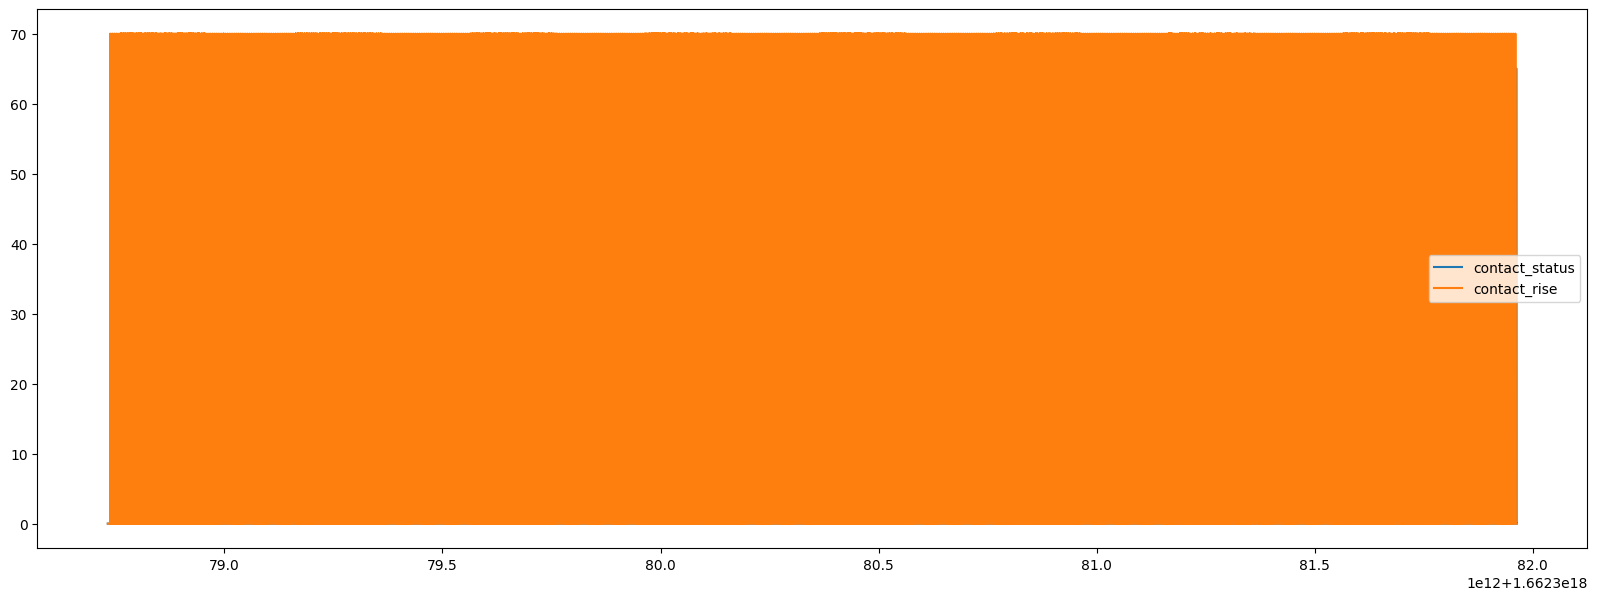

In [73]:
#find the rising peak
# contact_peaks_idx, contact_peak_magnitude = signal.find_peaks(contact_case_int, height=0.4, distance=30)
contact_case_diff = np.diff(contact_case) #out[i] = a[i+1] - a[i] if positive then at idx i the
contact_case_diff = np.insert(contact_case_diff, 0, 0)
contact_rise_idx = np.where(contact_case_diff > 0.4)[0]

contact_rise = [0 for i in range(len(contact_case))]
for index in contact_rise_idx:
    contact_rise[index] = 70


plt.figure(figsize=(20,7))
plt.plot(contact_case_ts, contact_case)
plt.plot(contact_case_ts, contact_rise)
plt.legend(['contact_status', 'contact_rise'])


label_contact_case = np.array(contact_case)[contact_rise_idx+1]
np.unique(label_contact_case, return_counts=True), len(label_contact_case)

((array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
         13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
         26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
         39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
         52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
         65.]),
  array([ 24,   5,  64,  63,  53,  48,  43,  91,  39,   5,  56,  40,  46,
          46,  39, 102,  22,   5,  44,  68,  51,  46,  51,  64,  36,   5,
          55,  70,  60,  45,  30,  69,  46,   5,  52,  71,  54,  55,  40,
          86,  68,   5,  42,  56,  32,  39,  51,  67,  40,   5,  41,  63,
          54,  52,  34,  78,  58,   5,  71,  54,  66,  46,  61, 112,  52,
           5])),
 3151)

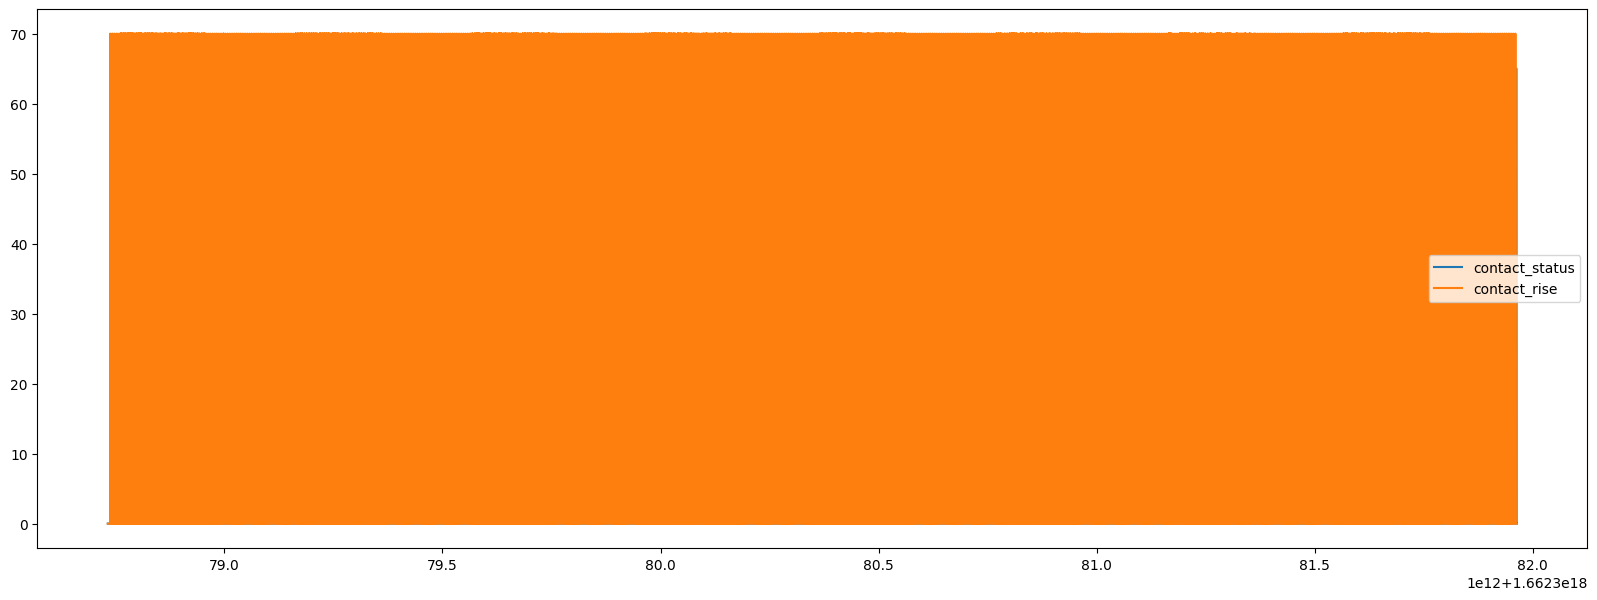

In [72]:
#find the rising peak
# contact_peaks_idx, contact_peak_magnitude = signal.find_peaks(contact_case_int, height=0.4, distance=30)
contact_case_diff_int = np.diff(contact_case_int) #out[i] = a[i+1] - a[i] if positive then at idx i the
contact_case_diff_int = np.insert(contact_case_diff_int, 0, 0)
contact_rise_idx = np.where(contact_case_diff_int > 0.4)[0]

contact_rise_int = [0 for i in range(len(contact_case_int))]
for index in contact_rise_idx:
    contact_rise_int[index] = 70


plt.figure(figsize=(20,7))
plt.plot(contact_case_ts_int, contact_case_int)
plt.plot(contact_case_ts_int, contact_rise_int)
plt.legend(['contact_status', 'contact_rise'])



label_contact_case = np.array(contact_case_int)[contact_rise_idx+1]
np.unique(label_contact_case, return_counts=True), len(label_contact_case)

In [32]:
sum(np.array(contact_rise_int) > 0)

3151

In [34]:
s = '1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  4.  4.  4. 4.  4.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  8. 8.  8.  8.  8.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 13. 13. 13. 13. 13. 14. 14. 14. 14. 14. 15. 15. 15. 15. 15. 16. 16. 16. 16. 16. 17. 17. 17. 17. 17.'

In [59]:
np.unique([int(c.strip()) for c in s.split('.')[:-1]], return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]))

[ 1.  1.  1. ... 65. 65. 65.]


In [26]:
label_contact_case = []
i=0
det = []
event_arrays=[]
for status_index in tqdm(contact_rise_idx):
    event_frames_list = []
    for j in range(-7, 8): 
        time_step = contact_case_ts_int[ status_index + j ]
        detect, event_array = filter_events_by_time(events, time_step, threshold=5000)
        #print(event_array)
        if detect:
            event_arrays.append(event_array)
            label_contact_case.append(np.array(contact_case_int)[status_index+1])
            break

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 3151/3151 [1:06:40<00:00,  1.27s/it]


In [28]:
len(event_arrays), len(label_contact_case)

(686, 686)

In [4]:
import pickle

with open('/home/hussain/tactile/data/raw/event_arrays.pkl', 'rb') as f:
    final_event_arrays=pickle.load(f)
    
with open('/home/hussain/tactile/data/raw/case.pkl', 'rb') as f:
    cases=pickle.load(f)

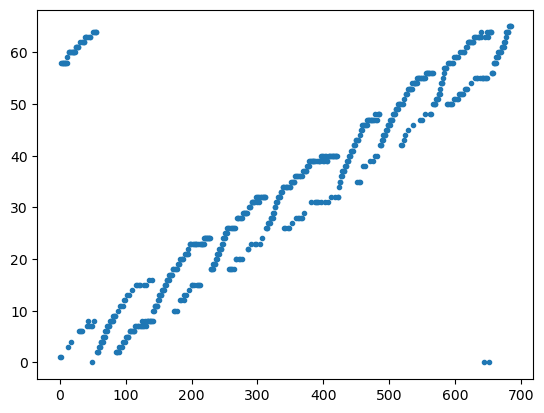

In [35]:
plt.plot(label_contact_case ,'.')

In [39]:
event_arrays[2][0, 2]

1662378767064803638

In [42]:
final_event_arrays=[]
for i in range(0,len(event_arrays)):
#     print(i)
    stacked=np.stack(event_arrays[i])
    final_event_arrays.append(stacked)

#X = np.stack(final_event_arrays)

In [43]:
len(final_event_arrays)

686

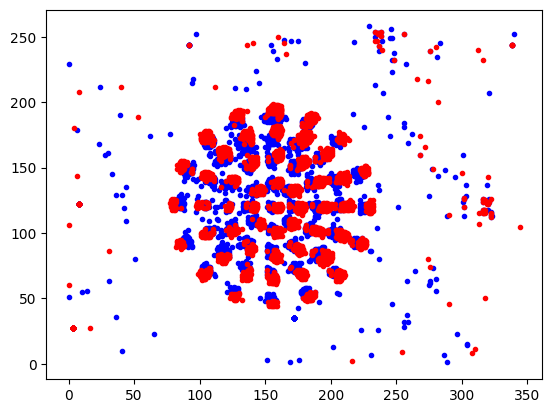

In [6]:
import matplotlib.pyplot as plt
b=138
plt.plot(final_event_arrays[b][:,0][final_event_arrays[b][:,3]==1],final_event_arrays[b][:,1][final_event_arrays[b][:,3]==1], 'b.')
plt.plot(final_event_arrays[b][:,0][final_event_arrays[b][:,3]==0],final_event_arrays[b][:,1][final_event_arrays[b][:,3]==0], 'r.')

In [7]:
cases[b]

8.0

In [15]:
np.array(list_of_rotations)[8]*180/np.pi

array([6.07713513, 6.07713513, 0.        ])

In [17]:
def generateFrames_modified(event_list, time_steps, im_height=260, im_width=346, im_channel=3, time_window=None):
        event_iterator = 0
        channel = 0
        x = [0, 0, 0]
        event_image = 255*np.ones((im_height, im_width, im_channel), dtype=np.float32)
        for ts in time_steps:
            
            for i in range(event_iterator, len(event_list)):
                event_iterator = i + 1
                event = np.copy(event_list[i]) #[x, y, ts, polarity]
                if (time_window==None) or (event[2] > ts - time_window):
                    if event[2] > ts:
                        event_image[201, 154, 0] = 0
                        channel = channel + 1
                        #print("cahnnel = ", channel)
                        break
                    else:
                        # print("ha")
                        x[channel] = x[channel] + 1
                        if event[3] > 0:
                            event_image[int(event[1]), int(event[0]), channel] = event_image[int(event[1]), int(event[0]), channel] + 1.0
                        else:
                            event_image[int(event[1]), int(event[0]), channel] = event_image[int(event[1]), int(event[0]), channel] - 1.0             
        
        return event_image

In [20]:
img = generateFrames_modified(event_array, [time_step-0.2e9, time_step-0.1e9, time_step])